##### Tutorial on making the plot Interactive #####
https://saturncloud.io/blog/python-matplotlib-make-3d-plot-interactive-in-jupyter-notebook/#:~:text=To%20make%20our%203D%20plot,using%20our%20mouse%20or%20trackpad. 

In [1]:
# %matplotlib notebook
%matplotlib widget
# %matplotlib inline
# I didn't have the line "%matplotlib inline" and then the plots weren't showing 

# What's really important is %matplotlib widget cause that's how I was able to make it interactive

In [2]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

import numpy as np

#### Successful 3D gradient ####

C:\Users\Joshua\AppData\Local\Temp\ipykernel_58348\2377330450.py:66: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(X_grid, Y_grid, Z_grid, c=color_new, cmap=custom_cmap, s=50, marker='o')
C:\Users\Joshua\AppData\Local\Temp\ipykernel_58348\2377330450.py:67: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(points_3D_test[:,0], points_3D_test[:,1], points_3D_test[:,2], c=color_new_transformation, cmap=custom_cmap_transformation, s=50, marker='o')


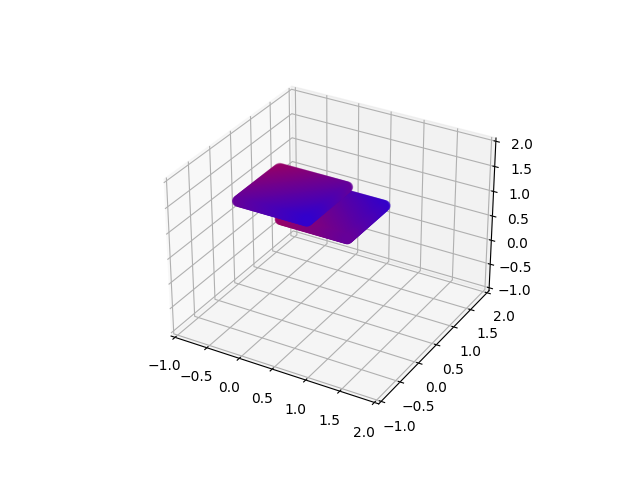

In [29]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from sklearn.preprocessing import normalize

# Create a custom colormap
cmap_colors = [(0, 'red'), (1, 'blue'), (1, 'green')]  # Colors for the combined dimension
cmap_colors_transformation = [(0, 'red'), (1, 'blue'), (1, 'green')]  # Colors for the combined dimension
custom_cmap = LinearSegmentedColormap.from_list('custom', cmap_colors)
custom_cmap_transformation = LinearSegmentedColormap.from_list('custom_transformation', cmap_colors_transformation)

# Create a 2D grid of values for both dimensions
num_dimensions = 2
num_points = 50
lowest_color_value = 0.2
highest_color_value = 0.8
z_value = 1.
x_color = np.linspace(lowest_color_value, highest_color_value/num_dimensions, num_points)
y_color = np.linspace(lowest_color_value, highest_color_value/num_dimensions, num_points)
X_color, Y_color = np.meshgrid(x_color, y_color)

# Combine data for both dimensions into a single variable
combined_data = X_color + Y_color  # You can use a different combination as needed

# Apply the custom colormap to the combined data
color = custom_cmap(combined_data)

# Make sure the color is in the right form (num of data points x 4), so we have a 
# color for each datapoint
color_new = color.reshape((-1, 4))
color_new_transformation = np.copy(color_new)

# Create a figure and axis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Set the boundaries of the square we are creating
min_x = 0
max_x = 1

min_y = 0
max_y = 1

z_value = 1
z_value_transformation = 2

# Create a grid of x and y values that will be the points of our "plane"
x_grid = np.linspace(min_x, max_x, num_points)
y_grid = np.linspace(min_y, max_y, num_points)

# Use np.meshgrid and reshaping to make this into a collection of points 
X_grid, Y_grid = np.meshgrid(x_grid, y_grid)
X_grid = X_grid.reshape((-1, 1))
Y_grid = Y_grid.reshape((-1, 1))
Z_grid = np.full(X_grid.shape, z_value)

points_3D = np.concatenate((X_grid, Y_grid, Z_grid), axis=1)

# Create a different z value to distinguish original and transformed matrix
Z_grid_2s = np.full(Z_grid.shape, z_value_transformation)

# Create transformed matrix
points_3D_of_2s = points_3D[:,:2]

points_3D_test = np.concatenate((points_3D_of_2s, Z_grid_2s), axis=1)

rotation_matrix = np.array([[0, -1, 0], [1, 0, 0], [0, 0, 1]])
points_3D_rotate = np.matmul(points_3D_test, rotation_matrix)

points_3D_test = points_3D_rotate

# Plot the 3D grid with the colormap representing both dimensions for both the original and the transformed matrix
ax.scatter(X_grid, Y_grid, Z_grid, c=color_new, cmap=custom_cmap, s=50, marker='o')
ax.scatter(points_3D_test[:,0], points_3D_test[:,1], points_3D_test[:,2], c=color_new_transformation, cmap=custom_cmap_transformation, s=50, marker='o')

# Set the 3D axis limits so we can view everything
min_val = min(points_3D_test.flatten())
max_val = max(points_3D_test.flatten())

ax.set_xlim(min_val, max_val)
ax.set_ylim(min_val, max_val)
ax.set_zlim(min_val, max_val)

# Show the plot
plt.show()

C:\Users\Joshua\AppData\Local\Temp\ipykernel_58348\4183416779.py:66: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(X_grid, Y_grid, Z_grid, c=color_new, cmap=custom_cmap, s=50, marker='o')
C:\Users\Joshua\AppData\Local\Temp\ipykernel_58348\4183416779.py:67: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(points_3D_test[:,0], points_3D_test[:,1], points_3D_test[:,2], c=color_new_transformation, cmap=custom_cmap_transformation, s=50, marker='o')


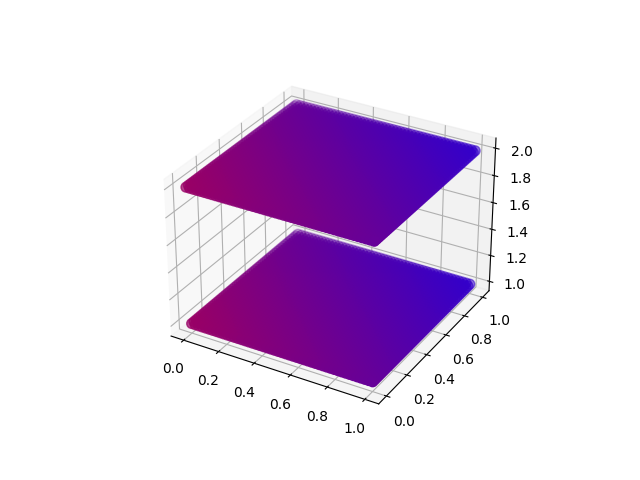

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from sklearn.preprocessing import normalize

# Create a custom colormap
cmap_colors = [(0, 'red'), (1, 'blue'), (1, 'green')]  # Colors for the combined dimension
cmap_colors_transformation = [(0, 'red'), (1, 'blue'), (1, 'green')]  # Colors for the combined dimension
custom_cmap = LinearSegmentedColormap.from_list('custom', cmap_colors)
custom_cmap_transformation = LinearSegmentedColormap.from_list('custom_transformation', cmap_colors_transformation)

# Create a 2D grid of values for both dimensions
num_dimensions = 2
num_points = 50
lowest_color_value = 0.2
highest_color_value = 0.8
z_value = 1.
x_color = np.linspace(lowest_color_value, highest_color_value/num_dimensions, num_points)
y_color = np.linspace(lowest_color_value, highest_color_value/num_dimensions, num_points)
X_color, Y_color = np.meshgrid(x_color, y_color)

# Combine data for both dimensions into a single variable
combined_data = X_color + Y_color  # You can use a different combination as needed

# Apply the custom colormap to the combined data
color = custom_cmap(combined_data)

# Create a figure and axis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# reshape x and y to match what is expected
min_x = 0
max_x = 1

min_y = 0
max_y = 1

min_z = 0
max_z = 1

x_grid = np.linspace(min_x, max_x, num_points)
y_grid = np.linspace(min_y, max_y, num_points)

X_grid, Y_grid = np.meshgrid(x_grid, y_grid)
X_grid = X_grid.reshape((-1, 1))
Y_grid = Y_grid.reshape((-1, 1))
Z_grid = np.full(X_grid.shape, z_value)

color_new = color.reshape((-1, 4))
color_new_transformation = np.copy(color_new)

points_3D = np.concatenate((X_grid, Y_grid, Z_grid), axis=1)

Z_grid_2s = np.full(Z_grid.shape, 2)

points_3D_of_2s = points_3D[:,:2]

points_3D_test = np.concatenate((points_3D_of_2s, Z_grid_2s), axis=1)

rotation_matrix = np.array([[0, -1, 0], [1, 0, 0], [0, 0, 1]])
points_3D_rotate = np.matmul(points_3D_test, rotation_matrix)

points_3D_test = points_3D_rotate
# Plot the 3D grid with the colormap representing both dimensions
ax.scatter(X_grid, Y_grid, Z_grid, c=color_new, cmap=custom_cmap, s=50, marker='o')
ax.scatter(points_3D_test[:,0], points_3D_test[:,1], points_3D_test[:,2], c=color_new_transformation, cmap=custom_cmap_transformation, s=50, marker='o')

min_val = min()

# Show the plot
plt.show()

C:\Users\Joshua\AppData\Local\Temp\ipykernel_58348\4183416779.py:66: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(X_grid, Y_grid, Z_grid, c=color_new, cmap=custom_cmap, s=50, marker='o')
C:\Users\Joshua\AppData\Local\Temp\ipykernel_58348\4183416779.py:67: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(points_3D_test[:,0], points_3D_test[:,1], points_3D_test[:,2], c=color_new_transformation, cmap=custom_cmap_transformation, s=50, marker='o')


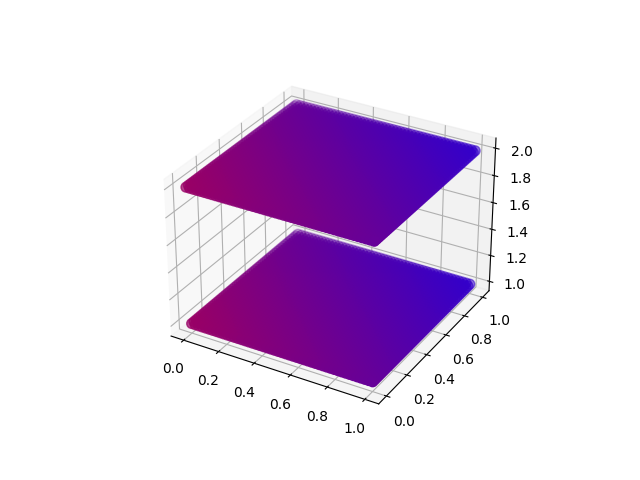

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from sklearn.preprocessing import normalize

# Create a custom colormap
cmap_colors = [(0, 'red'), (1, 'blue'), (1, 'green')]  # Colors for the combined dimension
cmap_colors_transformation = [(0, 'red'), (1, 'blue'), (1, 'green')]  # Colors for the combined dimension
custom_cmap = LinearSegmentedColormap.from_list('custom', cmap_colors)
custom_cmap_transformation = LinearSegmentedColormap.from_list('custom_transformation', cmap_colors_transformation)

# Create a 2D grid of values for both dimensions
num_dimensions = 2
num_points = 50
lowest_color_value = 0.2
highest_color_value = 0.8
z_value = 1.
x_color = np.linspace(lowest_color_value, highest_color_value/num_dimensions, num_points)
y_color = np.linspace(lowest_color_value, highest_color_value/num_dimensions, num_points)
X_color, Y_color = np.meshgrid(x_color, y_color)

# Combine data for both dimensions into a single variable
combined_data = X_color + Y_color  # You can use a different combination as needed

# Apply the custom colormap to the combined data
color = custom_cmap(combined_data)

# Create a figure and axis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# reshape x and y to match what is expected
min_x = 0
max_x = 1

min_y = 0
max_y = 1

min_z = 0
max_z = 1

x_grid = np.linspace(min_x, max_x, num_points)
y_grid = np.linspace(min_y, max_y, num_points)

X_grid, Y_grid = np.meshgrid(x_grid, y_grid)
X_grid = X_grid.reshape((-1, 1))
Y_grid = Y_grid.reshape((-1, 1))
Z_grid = np.full(X_grid.shape, z_value)

color_new = color.reshape((-1, 4))
color_new_transformation = np.copy(color_new)

points_3D = np.concatenate((X_grid, Y_grid, Z_grid), axis=1)

Z_grid_2s = np.full(Z_grid.shape, 2)

points_3D_of_2s = points_3D[:,:2]

points_3D_test = np.concatenate((points_3D_of_2s, Z_grid_2s), axis=1)

rotation_matrix = np.array([[0, -1, 0], [1, 0, 0], [0, 0, 1]])
points_3D_rotate = np.matmul(points_3D_test, rotation_matrix)

points_3D_test = points_3D_rotate
# Plot the 3D grid with the colormap representing both dimensions
ax.scatter(X_grid, Y_grid, Z_grid, c=color_new, cmap=custom_cmap, s=50, marker='o')
ax.scatter(points_3D_test[:,0], points_3D_test[:,1], points_3D_test[:,2], c=color_new_transformation, cmap=custom_cmap_transformation, s=50, marker='o')

min_val = min()

# Show the plot
plt.show()

#### Homography Explained With Code ####
https://docs.opencv.org/4.x/d9/dab/tutorial_homography.html 

#### Youtube Video Explaining Homography ####

- 2x2 Image Transformations: https://youtu.be/K2XLXlyPqCA 

- 3x3 Image Transformations: https://www.youtube.com/watch?v=B8kMB6Hv2eI

- Homography: https://www.youtube.com/watch?v=l_qjO4cM74o 